# Common Task 1. Electron/photon classification

In [ ]:
#@title Download the dataset
!wget -O photons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
!wget -O electrons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5

--2025-03-17 14:49:11--  https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.170.17, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703858 (114M) [application/octet-stream]
Saving to: ‘photons.hdf5’

photons.hdf5        100%[===================>] 114.16M  14.1MB/s    in 8.4s    

2025-03-17 14:49:20 (13.5 MB/s) - ‘photons.hdf5’ saved [119703858/119703858]

--2025-03-17 14:49:20--  https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.170.17, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [applicatio

In [ ]:
#@title Load Dataset
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchsummary import summary

from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

# Seeding
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
gen = torch.Generator().manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# The datasets fits into the RAM so I'll load them entirely
f = h5py.File('photons.hdf5', 'r')
p_x = f['X'][:]
p_y = f['y'][:]

f = h5py.File('electrons.hdf5', 'r')
e_x = f['X'][:]
e_y = f['y'][:]

Using device: cuda


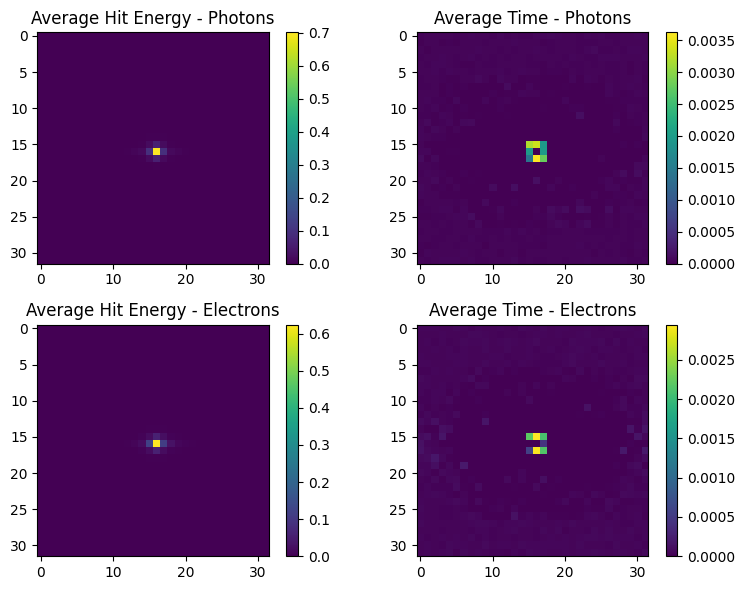

In [ ]:
#@title Visualizing the data

avg_p = np.mean(p_x, axis=0)
avg_p_energy, avg_p_time = avg_p[..., 0], avg_p[..., 1]

avg_e = np.mean(e_x, axis=0)
avg_e_energy, avg_e_time = avg_e[..., 0], avg_e[..., 1]

plt.figure(figsize=(8, 6))

# Photon Plots (Top Row)
plt.subplot(2, 2, 1)
plt.imshow(avg_p_energy, cmap='viridis', vmin=0, vmax=np.max(avg_p_energy))
plt.title('Average Hit Energy - Photons')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(avg_p_time, cmap='viridis', vmin=0, vmax=np.max(avg_p_time))
plt.title('Average Time - Photons')
plt.colorbar()

# Electron Plots (Bottom Row)
plt.subplot(2, 2, 3)
plt.imshow(avg_e_energy, cmap='viridis', vmin=0, vmax=np.max(avg_e_energy))
plt.title('Average Hit Energy - Electrons')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(avg_e_time, cmap='viridis', vmin=0, vmax=np.max(avg_e_time))
plt.title('Average Time - Electrons')
plt.colorbar()

plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
# Combine data and create labels
X = np.concatenate([p_x, e_x], axis=0)
y = np.concatenate([p_y, e_y], axis=0)

del p_x, e_x, p_y, e_y

In [ ]:
# Create dataset
X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
y = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X, y)

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.2, 0.1], generator=gen)

In [ ]:
# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Architecture
The model architecture contains an initial 5x5 convolutional layer, 3 ResNet blocks, followed by a dropout layer and a fully-connected layer.

Since the data sample is only 32x32 size, I used 5x5 kernel for the initial convolutional layer instead of the standard 7x7 kernel size.



In [ ]:
#@title ResNet
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.downsample = out_channels//in_channels

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.downsample > 1:
            X = self.shortcut(X)

        Y = self.relu(Y + X)
        return Y

def block_layers(in_channels, out_channels, num_residuals):
    layers = []
    for _ in range(num_residuals):
        layers.append(BasicBlock(in_channels, out_channels))
    return nn.Sequential(*layers)

b1 = nn.Sequential(nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=1),
                   nn.BatchNorm2d(32),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2))

b2 = block_layers(32, 32, 2)
b3 = block_layers(32, 64, 1)
b4 = block_layers(64, 64, 2)

net = nn.Sequential(b1, b2, b3, b4,
                    nn.Dropout(0.5),
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(64, 1))
model = net.to(device)
summary(model, (2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]           1,632
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
         MaxPool2d-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 32, 15, 15]           9,248
       BatchNorm2d-6           [-1, 32, 15, 15]              64
              ReLU-7           [-1, 32, 15, 15]               0
            Conv2d-8           [-1, 32, 15, 15]           9,248
       BatchNorm2d-9           [-1, 32, 15, 15]              64
             ReLU-10           [-1, 32, 15, 15]               0
       BasicBlock-11           [-1, 32, 15, 15]               0
           Conv2d-12           [-1, 32, 15, 15]           9,248
      BatchNorm2d-13           [-1, 32, 15, 15]              64
             ReLU-14           [-1, 32,

## Training Setup



In [ ]:
def evaluate(model, device, data_loader, show=True):
    test_loss, accuracy = 0.0, 0.0
    predictions, targets = [], []

    model.eval()
    with torch.no_grad():
      for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X).squeeze()
        test_loss += F.binary_cross_entropy_with_logits(logits, y).item()
        pred = logits.ge(0.).byte()
        accuracy += pred.eq(y.byte()).float().mean().item()

        y_pred = torch.sigmoid(logits)

        predictions.append(y_pred.tolist())
        targets.append(y.tolist())

    # Compute ROC score
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    fpr, tpr, _ = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)

    test_loss /= len(data_loader)
    accuracy /= len(data_loader)
    if show:
        print(f'Test set: Average loss: {test_loss:.4f}\nAccuracy: {accuracy:.4f}\nROC AUC: {roc_auc:.4f}')
    return test_loss, accuracy, roc_auc, fpr, tpr

In [ ]:
def train(model, device, data_loader, val_loader, num_epochs):
    train_loss, train_acc = [], []
    val_loss, val_acc, roc_scores = [], [], []

    for epoch in range(1, num_epochs+1):
      print(f"Epoch {epoch}/{num_epochs}")

      epoch_loss, epoch_acc = 0, 0
      model.train()
      for data in tqdm(data_loader, total=len(data_loader)):
          X, y = data[0].to(device), data[1].to(device)
          optimizer.zero_grad()
          y_pred = model(X).squeeze()
          loss = F.binary_cross_entropy_with_logits(y_pred, y)
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

          pred = y_pred.ge(0.).byte()
          acc = pred.eq(y.byte()).float().mean()
          epoch_acc += acc.item()

      train_loss.append(epoch_loss/len(data_loader))
      train_acc.append(epoch_acc/len(data_loader))
      print('Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}'.format(epoch, train_loss[epoch-1], train_acc[epoch-1]))

      # Validation
      val_loss_epoch, val_acc_epoch, roc_score, _, _ = evaluate(model, device, val_loader, show=False)
      val_loss.append(val_loss_epoch)
      val_acc.append(val_acc_epoch)
      roc_scores.append(roc_score)
      print('Epoch: {}, Val loss: {:.4f}, Val accuracy: {:.4f}'.format(epoch, val_loss[epoch-1], val_acc[epoch-1]))

      scheduler.step(val_loss_epoch)

    return train_loss, train_acc, val_loss, val_acc, roc_scores

In [ ]:
# Initialize
lr = 1e-3
weight_decay = 1e-4

model = net.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

## Training Loop

In [ ]:
train_loss, train_acc, val_loss, val_acc, roc_scores = train(model, device, data_loader=train_loader, val_loader=val_loader, num_epochs=30)

Epoch 1/30


100%|██████████| 5447/5447 [00:47<00:00, 114.08it/s]


Epoch: 1, Train loss: 0.6244, Train accuracy: 0.6547
Epoch: 1, Val loss: 0.6932, Val accuracy: 0.5800
Epoch 2/30


100%|██████████| 5447/5447 [00:47<00:00, 113.52it/s]


Epoch: 2, Train loss: 0.5856, Train accuracy: 0.6993
Epoch: 2, Val loss: 0.5788, Val accuracy: 0.7049
Epoch 3/30


100%|██████████| 5447/5447 [00:47<00:00, 114.46it/s]


Epoch: 3, Train loss: 0.5761, Train accuracy: 0.7068
Epoch: 3, Val loss: 0.5765, Val accuracy: 0.7098
Epoch 4/30


100%|██████████| 5447/5447 [00:47<00:00, 114.25it/s]


Epoch: 4, Train loss: 0.5713, Train accuracy: 0.7109
Epoch: 4, Val loss: 0.5862, Val accuracy: 0.6993
Epoch 5/30


100%|██████████| 5447/5447 [00:47<00:00, 114.45it/s]


Epoch: 5, Train loss: 0.5680, Train accuracy: 0.7134
Epoch: 5, Val loss: 0.6759, Val accuracy: 0.5826
Epoch 6/30


100%|██████████| 5447/5447 [00:47<00:00, 114.35it/s]


Epoch: 6, Train loss: 0.5655, Train accuracy: 0.7155
Epoch: 6, Val loss: 0.9364, Val accuracy: 0.5101
Epoch 7/30


100%|██████████| 5447/5447 [00:47<00:00, 114.44it/s]


Epoch: 7, Train loss: 0.5637, Train accuracy: 0.7164
Epoch: 7, Val loss: 0.7211, Val accuracy: 0.5618
Epoch 8/30


100%|██████████| 5447/5447 [00:47<00:00, 113.76it/s]


Epoch: 8, Train loss: 0.5520, Train accuracy: 0.7263
Epoch: 8, Val loss: 0.5496, Val accuracy: 0.7272
Epoch 9/30


100%|██████████| 5447/5447 [00:47<00:00, 114.38it/s]


Epoch: 9, Train loss: 0.5491, Train accuracy: 0.7284
Epoch: 9, Val loss: 0.5474, Val accuracy: 0.7300
Epoch 10/30


100%|██████████| 5447/5447 [00:47<00:00, 114.36it/s]


Epoch: 10, Train loss: 0.5478, Train accuracy: 0.7294
Epoch: 10, Val loss: 0.5461, Val accuracy: 0.7301
Epoch 11/30


100%|██████████| 5447/5447 [00:47<00:00, 114.18it/s]


Epoch: 11, Train loss: 0.5469, Train accuracy: 0.7300
Epoch: 11, Val loss: 0.5458, Val accuracy: 0.7300
Epoch 12/30


100%|██████████| 5447/5447 [00:47<00:00, 114.18it/s]


Epoch: 12, Train loss: 0.5461, Train accuracy: 0.7304
Epoch: 12, Val loss: 0.5445, Val accuracy: 0.7310
Epoch 13/30


100%|██████████| 5447/5447 [00:47<00:00, 114.19it/s]


Epoch: 13, Train loss: 0.5455, Train accuracy: 0.7305
Epoch: 13, Val loss: 0.5456, Val accuracy: 0.7297
Epoch 14/30


100%|██████████| 5447/5447 [00:47<00:00, 114.43it/s]


Epoch: 14, Train loss: 0.5447, Train accuracy: 0.7315
Epoch: 14, Val loss: 0.5438, Val accuracy: 0.7314
Epoch 15/30


100%|██████████| 5447/5447 [00:47<00:00, 114.12it/s]


Epoch: 15, Train loss: 0.5444, Train accuracy: 0.7313
Epoch: 15, Val loss: 0.5439, Val accuracy: 0.7312
Epoch 16/30


100%|██████████| 5447/5447 [00:47<00:00, 114.30it/s]


Epoch: 16, Train loss: 0.5437, Train accuracy: 0.7319
Epoch: 16, Val loss: 0.5463, Val accuracy: 0.7311
Epoch 17/30


100%|██████████| 5447/5447 [00:47<00:00, 113.97it/s]


Epoch: 17, Train loss: 0.5432, Train accuracy: 0.7322
Epoch: 17, Val loss: 0.5455, Val accuracy: 0.7303
Epoch 18/30


100%|██████████| 5447/5447 [00:47<00:00, 114.99it/s]


Epoch: 18, Train loss: 0.5426, Train accuracy: 0.7326
Epoch: 18, Val loss: 0.5433, Val accuracy: 0.7319
Epoch 19/30


100%|██████████| 5447/5447 [00:47<00:00, 114.25it/s]


Epoch: 19, Train loss: 0.5422, Train accuracy: 0.7331
Epoch: 19, Val loss: 0.5443, Val accuracy: 0.7296
Epoch 20/30


100%|██████████| 5447/5447 [00:47<00:00, 114.53it/s]


Epoch: 20, Train loss: 0.5417, Train accuracy: 0.7333
Epoch: 20, Val loss: 0.5433, Val accuracy: 0.7326
Epoch 21/30


100%|██████████| 5447/5447 [00:47<00:00, 114.39it/s]


Epoch: 21, Train loss: 0.5412, Train accuracy: 0.7333
Epoch: 21, Val loss: 0.5450, Val accuracy: 0.7315
Epoch 22/30


100%|██████████| 5447/5447 [00:47<00:00, 114.72it/s]


Epoch: 22, Train loss: 0.5409, Train accuracy: 0.7339
Epoch: 22, Val loss: 0.5424, Val accuracy: 0.7325
Epoch 23/30


100%|██████████| 5447/5447 [00:47<00:00, 114.71it/s]


Epoch: 23, Train loss: 0.5406, Train accuracy: 0.7339
Epoch: 23, Val loss: 0.5448, Val accuracy: 0.7299
Epoch 24/30


100%|██████████| 5447/5447 [00:47<00:00, 114.90it/s]


Epoch: 24, Train loss: 0.5403, Train accuracy: 0.7336
Epoch: 24, Val loss: 0.5429, Val accuracy: 0.7319
Epoch 25/30


100%|██████████| 5447/5447 [00:47<00:00, 113.60it/s]


Epoch: 25, Train loss: 0.5399, Train accuracy: 0.7339
Epoch: 25, Val loss: 0.5433, Val accuracy: 0.7317
Epoch 26/30


100%|██████████| 5447/5447 [00:47<00:00, 114.74it/s]


Epoch: 26, Train loss: 0.5397, Train accuracy: 0.7346
Epoch: 26, Val loss: 0.5431, Val accuracy: 0.7314
Epoch 27/30


100%|██████████| 5447/5447 [00:47<00:00, 114.38it/s]


Epoch: 27, Train loss: 0.5361, Train accuracy: 0.7366
Epoch: 27, Val loss: 0.5400, Val accuracy: 0.7340
Epoch 28/30


100%|██████████| 5447/5447 [00:47<00:00, 114.26it/s]


Epoch: 28, Train loss: 0.5357, Train accuracy: 0.7364
Epoch: 28, Val loss: 0.5400, Val accuracy: 0.7343
Epoch 29/30


100%|██████████| 5447/5447 [00:47<00:00, 113.82it/s]


Epoch: 29, Train loss: 0.5352, Train accuracy: 0.7370
Epoch: 29, Val loss: 0.5401, Val accuracy: 0.7339
Epoch 30/30


100%|██████████| 5447/5447 [00:47<00:00, 114.87it/s]


Epoch: 30, Train loss: 0.5352, Train accuracy: 0.7371
Epoch: 30, Val loss: 0.5404, Val accuracy: 0.7342


In [ ]:
test_loss, accuracy, roc_auc, fpr, tpr = evaluate(model, device, test_loader)

Test set: Average loss: 0.5401
Accuracy: 0.7335
ROC AUC: 0.8025


In [ ]:
torch.save(model.state_dict(), "resnet15_particle_classifier.pth")

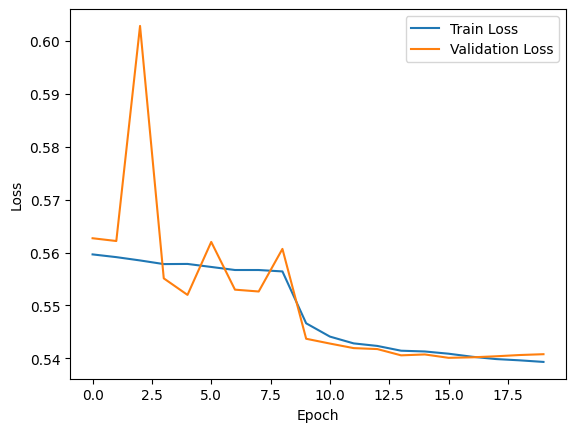

In [ ]:
# Plot loss curves
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

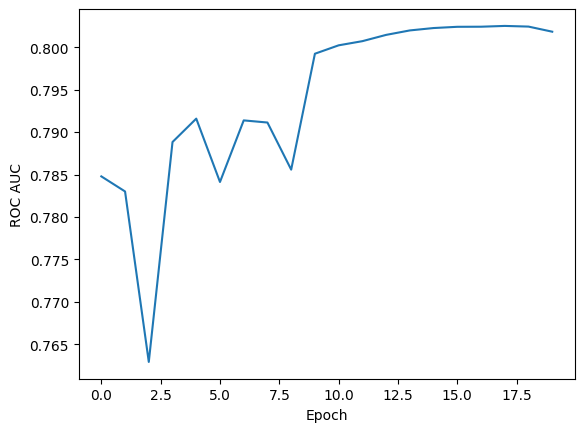

In [ ]:
plt.plot(roc_scores)
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.show()

## Evaluating the model on a sample


In [ ]:
#@title ResNet
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.downsample = out_channels//in_channels

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.downsample > 1:
            X = self.shortcut(X)

        Y = self.relu(Y + X)
        return Y

def block_layers(in_channels, out_channels, num_residuals):
    layers = []
    for _ in range(num_residuals):
        layers.append(BasicBlock(in_channels, out_channels))
    return nn.Sequential(*layers)

b1 = nn.Sequential(nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=1),
                   nn.BatchNorm2d(32),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2))

b2 = block_layers(32, 32, 2)
b3 = block_layers(32, 64, 1)
b4 = block_layers(64, 64, 2)

net = nn.Sequential(b1, b2, b3, b4,
                    nn.Dropout(0.5),
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(64, 1))


In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)

In [ ]:
model.load_state_dict(torch.load("resnet15_particle_classifier.pth", map_location=device))
model.eval()

In [ ]:
inputs = torch.randn(1, 2, 32, 32).to(device)
with torch.no_grad():
  logits = model(inputs)
  y_pred = torch.sigmoid(logits).cpu().item()
y_pred

0.0